# Fitbit Data Exploration: Making a prediction for the two weeks of missing data

By: Norrick McGee and Eric Escalante  
January 19, 2019  

In this Jupyter Notebook, we will use the Time Series Methology and fitbit data collected from 04/26/2018 to 12/06/2018 to predict two weeks worth of missing data; we will add our pridicted data in a separate csv file.

## Imports
**Import the necessary packages and their use cases for this project:**
> **pandas:** data frames and data manipulation  
> **numpy:** summary statistics  
> **matplotlib:** used for visualizations  
> **seasborn:** fancy visualizations  
> **datetime:** turn the dates into datetime objects / get day of week  
> **warning:** used to ignore python warnings  
> **statsmodels:** library of different statistical tests we will be performing thoughout the project

In [20]:
from acquire import acquire_fitbit

import numpy as np
import pandas as pd

import os
from datetime import datetime
import itertools
 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet

## Table of contents
1. [Project Planning](#project-planning)
1. [Acquisition](#acquisition)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)

## Project Planning <a name="project-planning"></a>

### Goals  
> Goals for the Project are:  
1. We will predict using different Time Series Methodologies the missing two weeks of Fitbit data
2. We will show the reasoning behind our preditions with visualizations and statistical findings
3. Finally we will create a viewable csv file with those pridictions so that you could see the endire dataset

### Deliverables

**_TODO:_**
> Summarization of the data:

### Data Dictionary & Domain Knowledge

So we have sixteen columns in our dataset. Let us understand what each one is. We will be adding more throughout the project.

> **activity_calories:** amount of calories burned throughout the day   
> **calories:** amount of calories consumed throughout the day  
> **carbs:** amount of carbs consumed throughout the day  
> **distance:** distance traveled  
> **fat:** amount of fat consumed throughout the day  
> **fiber:** amount of fiber comsumed throughout the day  
> **floors:** floors climbed  
> **mins_active_high:** minutes of high activity in the day   
> **mins_active_light:** minutes of light activity in the day  
> **mins_active_med:** minutes of moderate activity in the day  
> **mins_sedentary:** minutes the fit bit assums you are sitting down  
> **protien:** amount of protein consumed throughout the day  
> **sodium:** amount of sodium consumed throughout the day  
> **steps:** total amount of steps taken in a day  
> **total_calories:** total calories consumed throughout the day  
> **water:** metric desplays tracked water intake or set a consumption

### Hypotheses

**_TODO:_**  
> Hypotheses:

### Thoughts & Questions

> Thoughts:  
1. We should only use our test data once
2. Make sure we are resampling the data if we wanted to to differents training models within our original train data
3. Distance has more data: maybe we use distance to equate the amount of steps
>>1 miles to steps = 2112 steps  
2 miles to steps = 4224 steps  
3 miles to steps = 6336 steps  
4 miles to steps = 8448 steps  
5 miles to steps = 10560 steps  

> Questions: 
1. Where are we going to split our times?
2. What two weeks are we predicting?
3. What is the distance formula?

## Prepare the Environment

## Preparation <a name="preparation"></a>

In [25]:
df = pd.concat(acquire_fitbit())
df = df.convert_objects(convert_numeric=True, convert_dates=True)
df.index = pd.to_datetime(df.index)

In [26]:
def add_date_parts(df):
    '''
    Function to add columns based on date: month, day of month, day of week
    '''
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.day_name()
    
    return df

def nulls_by_col(df):
    '''
    Funciton used to find missing information in each column
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing/rows
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'pct_rows_missing': pct_missing})
    
    return cols_missing

def nulls_by_row(df):
    '''
    Function used to find missing information in each row
    '''
    num_cols_missing = df.isnull().sum(axis=1)
    pct_cols_missing = df.isnull().sum(axis=1)/df.shape[1]*100
    rows_missing = pd.DataFrame({'num_cols_missing': num_cols_missing, 'pct_cols_missing': pct_cols_missing})\
                     .reset_index().groupby(['num_cols_missing','pct_cols_missing']).count()\
                     .rename(index=str, columns={'index': 'num_rows'}).reset_index()
    
    return rows_missing

def df_summary(df):
    '''
    Funciton summarizes our created data frame with information on: shape, type & null info, desribe function from pandas library, null values by column, null values by row, and value counts
    '''
    print('--- Shape: {}'.format(df.shape))
    print('--- Info')
    df.info()
    print('--- Descriptions')
    print(df.describe(include='all'))
    print('--- Nulls By Column')
    print(nulls_by_col(df))
    print('--- Nulls By Row')
    print(nulls_by_row(df))

In [27]:
df = add_date_parts(df)

In [28]:
df_summary(df)

--- Shape: (719, 19)
--- Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719 entries, 2018-04-26 to 2018-12-28
Data columns (total 19 columns):
activity_calories    50 non-null float64
calories             482 non-null float64
carbs                247 non-null object
distance             225 non-null float64
fat                  247 non-null object
fiber                247 non-null object
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       188 non-null float64
protien              247 non-null object
sodium               247 non-null object
steps                20 non-null float64
total_calories       1 non-null float64
water                247 non-null object
month                719 non-null int64
day                  719 non-null int64
weekday              719 non-null object
dtypes: float64(10), int64(2), object(7)
memory usage: 112.3+ K

### Handle Missing Values


>- We do want to look where are current numbers land to see how we want to structure our null values
>- Option could be just to add a zero there; reasoning could because the person forgot to log his info
>- Could use the average because if these guys are so busy that they do not have time for side conversations they may just eat/do the same thing each day  
>- There are non-type or int + str types that we need to work on what to do in this case

In [29]:
for col in df.select_dtypes('number'):
    print(f'\n- {col} -')
    print(df[col].value_counts(bins=4, sort=False))


- activity_calories -
(-1.0, 249.75]     17
(249.75, 499.5]     7
(499.5, 749.25]     7
(749.25, 999.0]    19
Name: activity_calories, dtype: int64

- calories -
(-0.808, 201.75]    478
(201.75, 403.5]       0
(403.5, 605.25]       2
(605.25, 807.0]       2
Name: calories, dtype: int64

- distance -
(-0.013000000000000001, 3.0]    83
(3.0, 6.0]                      88
(6.0, 9.0]                      48
(9.0, 12.0]                      6
Name: distance, dtype: int64

- floors -
(-0.196, 48.75]    216
(48.75, 97.5]        2
(97.5, 146.25]       4
(146.25, 195.0]      3
Name: floors, dtype: int64

- mins_active_high -
(-0.155, 38.5]    142
(38.5, 77.0]       43
(77.0, 115.5]      36
(115.5, 154.0]      4
Name: mins_active_high, dtype: int64

- mins_active_light -
(-0.35, 87.25]      24
(87.25, 174.5]      53
(174.5, 261.75]    121
(261.75, 349.0]     27
Name: mins_active_light, dtype: int64

- mins_active_med -
(-0.079, 19.5]    161
(19.5, 39.0]       45
(39.0, 58.5]       15
(58.5, 78.0

**_Thoughts:_**
> We are going to try and use Facebooks Prophet to generate quick time series data to fill missing values

In [69]:
df['ds'] = df.index
df['y'] = df.distance

In [99]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.3)
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [110]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
927,2019-07-25,14.200005,12.127149,16.339830
928,2019-07-26,14.422992,12.277880,16.439928
929,2019-07-27,14.911175,12.698774,16.887700
930,2019-07-28,15.054186,13.010461,17.145237
931,2019-07-29,13.899851,11.789529,16.114248


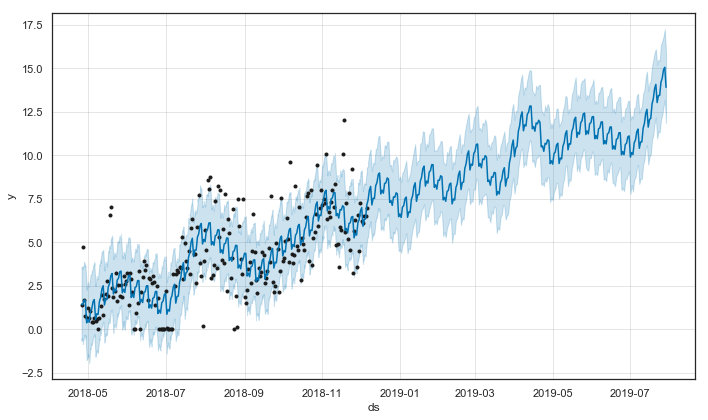

In [108]:
fig1 = m.plot(forecast)

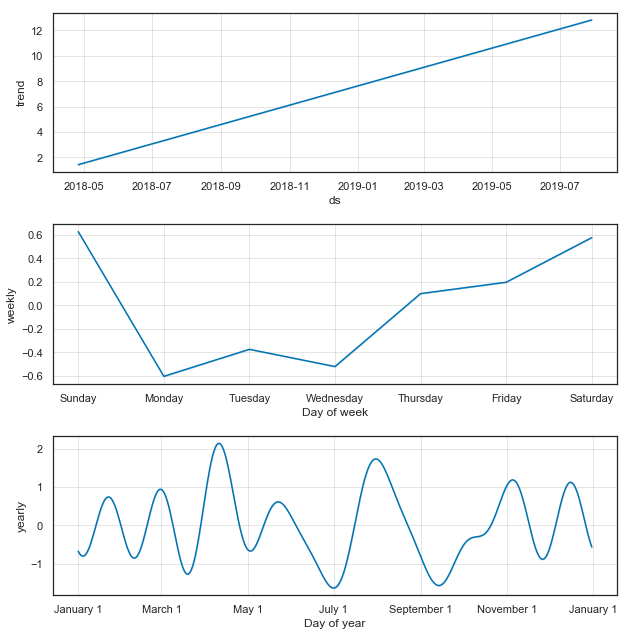

In [103]:
fig2 = m.plot_components(forecast)

In [104]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='30 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-08-08 00:00:00 and 2018-11-06 00:00:00


,horizon,mse,rmse,mae,mape,coverage
92,3 days,5.770147,2.402113,2.041369,10.103230,0.476190
63,4 days,5.891572,2.427256,2.073149,10.143929,0.428571
153,4 days,5.850779,2.418838,2.034480,10.138088,0.428571
33,4 days,5.777435,2.403630,2.026944,2.318450,0.428571
183,4 days,5.382053,2.319925,1.933352,2.307621,0.476190


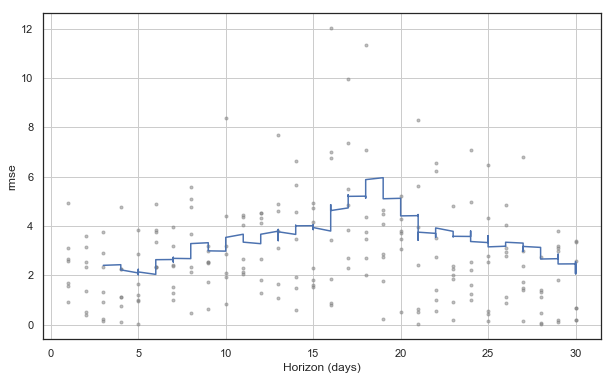

In [105]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

### Handle Duplicates

**_TODO:_**
> Do we have duplicated data??

### Handle Outliers

**_TODO:_**
> Personally do not want to remove outliers here; however we should be finding the missing values

### Re-Check Missing Values & Summary

In [33]:
df_summary(df)

--- Shape: (719, 21)
--- Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 719 entries, 2018-04-26 to 2018-12-28
Data columns (total 21 columns):
activity_calories    50 non-null float64
calories             482 non-null float64
carbs                247 non-null object
distance             225 non-null float64
fat                  247 non-null object
fiber                247 non-null object
floors               225 non-null float64
mins_active_high     225 non-null float64
mins_active_light    225 non-null float64
mins_active_med      225 non-null float64
mins_sedentary       188 non-null float64
protien              247 non-null object
sodium               247 non-null object
steps                20 non-null float64
total_calories       1 non-null float64
water                247 non-null object
month                719 non-null int64
day                  719 non-null int64
weekday              719 non-null object
ds                   719 non-null datetime64[ns]
y             

## Exploration  <a name="exploration"></a>

In [34]:
def createheatmap(df):
    '''
    Function we will use to create heatmaps with pretty specific parameters that keep these heatmaps uniform
    '''
    sns.set(style = "white")
    corrd = df.corr()
    mask = np.zeros_like(corrd, dtype=np.bool)    ### returns an array of zerros for NA's to fill each column; ensures each column is the same shape
    mask[np.triu_indices_from(mask)] = True       ### returns the indices for the upper-triangle of an (n, m) array.
    f, ax = plt.subplots(figsize=(15, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corrd, mask=mask, cmap=cmap, square=True, 
                xticklabels=True, yticklabels=True, 
                linewidths=.5, ax=ax)

def bin_feature(df, col, newcol, bin_cuts=[]):
    '''
    Function we will use to bin different columns during our exploration -> returns the dataframe with the column binned 
    '''
    labs = list(range(len(bin_cuts)))[1:]
    df[newcol] = pd.cut(df[col], bin_cuts, labels=labs, include_lowest=False)
    
    return df

def summary_stat(df, col_name):
    '''
    Function to provide median, min, and max of data in column -> returns a new small dataframe with the info
    '''
    df = pd.DataFrame({'Mean ' : str(round(np.mean(df[col_name]),2)),
         'Median' : str(np.median(df[col_name])),
         'Min' : str(np.min(df[col_name])),
         'Max' : str(np.max(df[col_name]))}, index=[0])
    
    return df

**_Thoughts:_**
> We want to see how each month looks stacked up together using the distance metric  
> We want to get a total amount so that we can potentially look at the rolling average  
> Instead of the distance we really do want to use **step count**

In [35]:
df.groupby('month').first()    ### Compute first of group values

,activity_calories,calories,carbs,distance,fat,fiber,floors,mins_active_high,mins_active_light,mins_active_med,mins_sedentary,protien,sodium,steps,total_calories,water,day,weekday,ds,y
month,,,,,,,,,,,,,,,,,,,,
4,566.0,0.0,0 g,1.38,0 g,0 g,2.0,0.0,93.0,0.0,702.0,0 g,0 mg,NaN,NaN,0 fl oz,26,Thursday,2018-04-26,NaN
5,419.0,0.0,0 g,1.22,0 g,0 g,0.0,2.0,167.0,13.0,919.0,0 g,0 mg,904.0,NaN,0 fl oz,1,Tuesday,2018-05-01,904.0
6,752.0,0.0,0 g,3.26,0 g,0 g,0.0,2.0,279.0,10.0,690.0,0 g,0 mg,0.0,NaN,0 fl oz,1,Friday,2018-06-01,0.0
7,67.0,0.0,0 g,2.22,0 g,0 g,4.0,0.0,232.0,0.0,821.0,0 g,0 mg,172.0,NaN,0 fl oz,1,Sunday,2018-07-01,172.0
8,972.0,0.0,0 g,7.48,0 g,0 g,15.0,96.0,259.0,9.0,608.0,0 g,0 mg,68.0,799.0,0 fl oz,27,Monday,2018-08-27,68.0
9,852.0,0.0,0 g,1.86,0 g,0 g,7.0,5.0,133.0,13.0,798.0,0 g,0 mg,NaN,NaN,0 fl oz,1,Saturday,2018-09-01,NaN
10,NaN,0.0,0 g,3.92,0 g,0 g,8.0,24.0,201.0,5.0,813.0,0 g,0 mg,NaN,NaN,0 fl oz,1,Monday,2018-10-01,NaN
11,NaN,0.0,0 g,7.14,0 g,0 g,11.0,80.0,164.0,12.0,698.0,0 g,0 mg,NaN,NaN,0 fl oz,1,Thursday,2018-11-01,NaN
12,NaN,0.0,0 g,7.27,0 g,0 g,7.0,67.0,233.0,22.0,527.0,0 g,0 mg,NaN,NaN,0 fl oz,1,Saturday,2018-12-01,NaN


**_Thoughts:_**
> Here we want to see if the total distance traveled has a trend by month  
> This person had a peak in distance traveled in November; he must have just gotten the FitBit in April  
> We can also add steps once we fill all missing values

In [36]:
df.groupby('month')[['distance', 'steps']].sum()    ### Compute each months total distance and total steps

,distance,steps
month,,
4,9.13,0.0
5,60.76,2710.0
6,56.34,0.0
7,101.18,529.0
8,157.33,275.0
9,109.65,0.0
10,177.94,0.0
11,198.61,0.0
12,39.59,0.0


**_Thoughts:_**
> Let's graph a boxplot so we can see the information regarding the shape, variability, and center (or median) of monthly distance

Text(0.5, 0, 'Month')

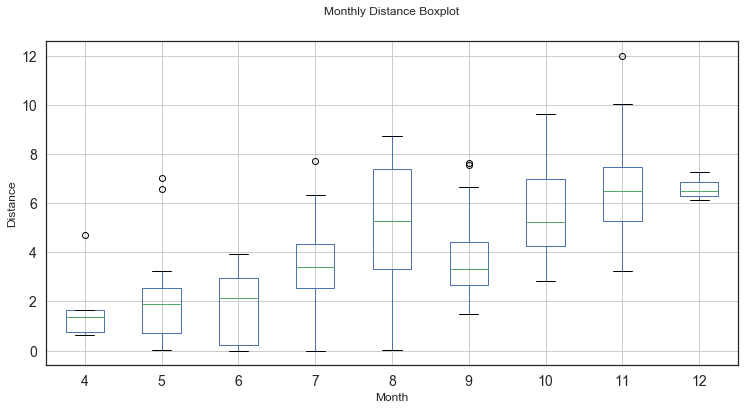

In [37]:
df.boxplot(column = 'distance', by = 'month', figsize=(12,6))

plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.title('')
plt.suptitle('Monthly Distance Boxplot')
plt.ylabel('Distance')
plt.xlabel('Month')

**_Thoughts:_**
> Individuals walked distance increased significantly in August.  
> His/Her distance remained stable in November and December. However, in May through August, it rose suddenly.  
> In August and September, there was a sudden drop in distance.

Text(0, 0.5, 'Distance')

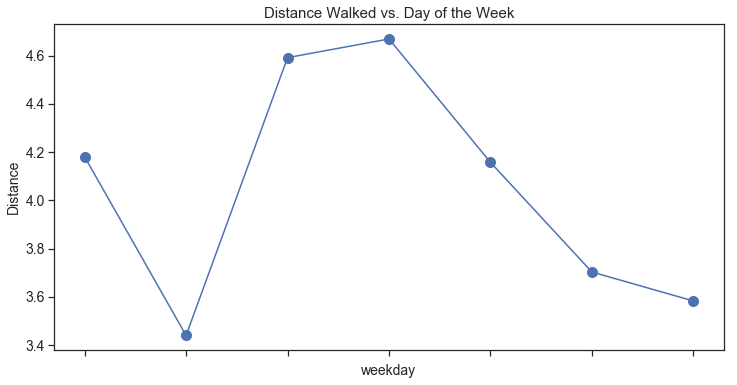

In [38]:
fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(111)
DOWdf = df.groupby(by='weekday').mean()
meanDOW = DOWdf['distance']
meanDOW.plot(linestyle='-', marker='o', markersize=10)

ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

plt.xticks(fontsize=10)  
plt.yticks(fontsize=14)  

plt.title('Distance Walked vs. Day of the Week', fontsize=15)
plt.xlabel('Weekday', fontsize=14)
plt.xlabel('Day of the Week')
plt.xlabel(meanDOW.index.name, fontsize=14)
plt.ylabel('Distance', fontsize=14)

**_TODO:_**
> Need to write a detailed breakdown of what the data shows us here  
> Need to update code to show what day of the week each tickmark represents

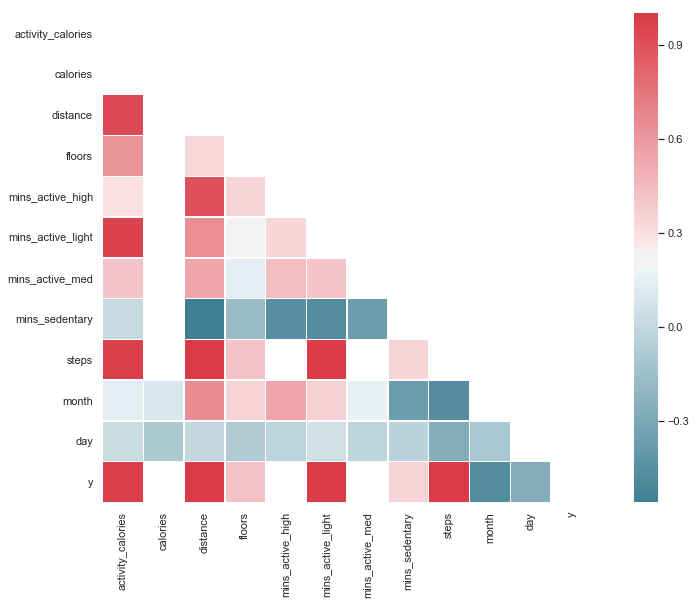

In [39]:
createheatmap(df.drop(columns=['total_calories']))

**_TODO:_**
> Need to figure out different correlations here speak to them...  
> Currently - Total year has too many missing values & year only has the one  
> Which variables are we going to start binning?  
> Which statistical models are we going to start preparing for?

**_TODO: Workday hours, Non workday hours, Weekend hours_**
> Can we create two seperate df for each test  
> New df's will include:
> 1. Days of the week
> 2. Hours from 9 to 5 (as type int)

### Train-Test Split

**_TODO:_**
> 1. Modeling Time Series Using Parametric Methods  
> 2. Prophet

### Visualizations

**_TODO:_**
> **TIME TO SHINE!**

### Statistical Tests

In [40]:
def calculate_r2(Actual_Y, Estimated_Y):
    '''
    Function that calculates R squared
    '''
    return float(1 - sum((Actual_Y-Estimated_Y)**2 ) / sum((Actual_Y-Actual_Y.mean(axis=0))**2))

def calculate_rmse(Actual_Y, Estimated_Y):
    '''
    Function that calculates Root Mean Squared Error
    '''
    return(math.sqrt(sum((Actual_Y-Estimated_Y )**2 ) / Actual_Y.shape[0]))

def evaluate(actual, predictions, output=True):
    '''
    Function calculates the mean squared error and the root mean square error by taking the square root of the mse
    '''
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

### Summarize Conclusions

**_TODO:_**
> Summarize our statistical findings

## Modeling <a name="modeling"></a>

### Feature Engineering & Selection

In [41]:
def new_features(df):
    '''
    Function used to create new features -> returns the original dataframe with new features added
    '''
    return df

def plot_data_and_predictions(predictions, label):
    '''
    Function plots using matplotlib
    '''
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()

### Add plot_and_eval function from curriculum

### Train & Test Models

**_TODO:_**
> Build some models here:
1. Would like to build a few functions here so that we could do differnt ML methods
2. What is going to be our goal??
3. I think we need to separate the data into different slices (i.e. use Sunday thru Friday to predict Saturday; Monday thru Saturday to predict Sunday... and so on)

### Summarize Conclusions

**_TODO:_**
> Sumarize our training and test builds  
> Create the CSV  
> Find differnt ways to improve  